In [1]:
# read all the data from the csv files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# read the data from the csvs files in the folder
data = []
for file in os.listdir("."):
    if file.endswith(".csv"):
        data.append(pd.read_csv(file).to_dict('records')[0])
        data[-1]['step'] = file[16:-4] 
df = pd.DataFrame(data)
df.sort_values(by=['displayName'], inplace=True)
df

,displayName,status,createdOn,duration,gpt_coherence,gpt_coherence_pass_rate(%),gpt_fluency,gpt_fluency_pass_rate(%),gpt_groundedness,gpt_groundedness_pass_rate(%),gpt_relevance,gpt_relevance_pass_rate(%),step
1,eval_step_0,Completed,2023-10-10T11:50:28.0940673+00:00,60723.3949,4.14,82.14,4.15,75.00,3.41,42.86,2.71,39.29,baseline
0,eval_step_1,Completed,2023-10-10T12:55:50.6373248+00:00,76317.9513,2.69,42.86,3.48,64.29,3.64,46.43,2.96,46.43,system_prompt
2,eval_step_2,Completed,2023-10-10T13:30:19.1139808+00:00,753599.5701,3.37,51.85,3.96,81.48,3.85,55.56,3.04,48.15,chunk_size
3,eval_step_3,Completed,2023-10-10T13:48:24.1054048+00:00,58688.1524,3.57,64.29,3.81,71.43,4.43,78.57,3.61,64.29,infer_intent


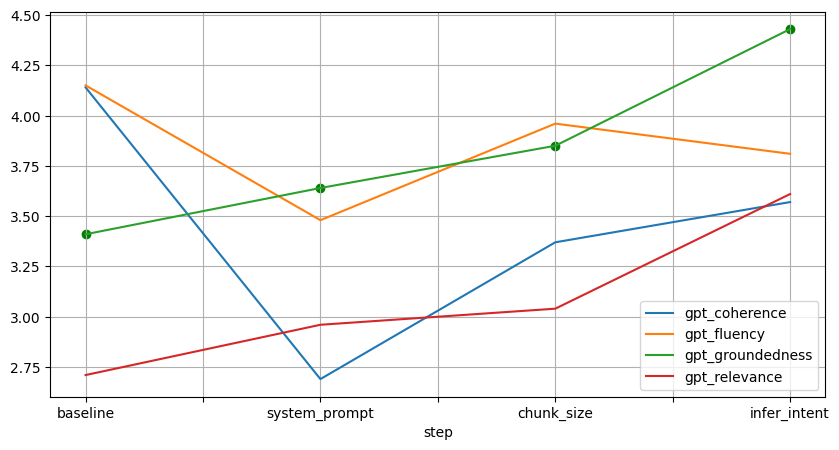

In [2]:
# create a line plot for the data
df_focused = df[['step', 'gpt_coherence', 'gpt_fluency', 'gpt_groundedness', 'gpt_relevance']]
df_focused.plot(x='step', figsize=(10, 5))
# add dots to the line plot
plt.scatter(df_focused['step'], df_focused['gpt_groundedness'], color='green')
# add a grid
plt.grid()
# save the plot
plt.savefig('metrics.png')
